In [1]:
# Install required packages for Google Colab
!pip install mlflow
!pip install xgboost
!pip install pyyaml
!pip install pyngrok
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.4

In [2]:
import pandas as pd
import numpy as np
import joblib
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import yaml
import os, subprocess, time, socket, pathlib
import logging
from contextlib import nullcontext
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [3]:
# Thư mục lưu run/artifact
MLFLOW_DIR = "/content/mlruns"
pathlib.Path(MLFLOW_DIR).mkdir(parents=True, exist_ok=True)

# Khởi chạy MLflow UI nền, ghi log
log_path = "/content/mlflow_ui.log"
ui_cmd = f"mlflow ui --backend-store-uri file:{MLFLOW_DIR} --port 5000 --host 0.0.0.0"
ui_proc = subprocess.Popen(
    ["bash","-lc", ui_cmd],
    stdout=open(log_path, "w"),
    stderr=subprocess.STDOUT,
)

# Đợi cổng 5000 sẵn sàng (tối đa ~60s)
def wait_port(host="127.0.0.1", port=5000, timeout=60):
    start = time.time()
    while time.time() - start < timeout:
        try:
            with socket.create_connection((host, port), timeout=1):
                return True
        except OSError:
            time.sleep(1)
    return False

ready = wait_port("127.0.0.1", 5000, 60)
print("MLflow UI ready:", ready, " | log:", log_path)
if not ready:
    # In vài dòng cuối log để debug nếu cần
    print("=== tail log ===")
    print("\n".join(open(log_path).read().splitlines()[-60:]))

MLflow UI ready: True  | log: /content/mlflow_ui.log


In [4]:
from pyngrok import ngrok, conf
from google.colab import userdata  # lấy secrets

# Lấy token từ Secrets (ưu tiên), fallback sang biến môi trường nếu có
token = userdata.get("NGROK_AUTH_TOKEN") or os.environ.get("NGROK_AUTH_TOKEN")
if not token:
    raise RuntimeError("Chưa tìm thấy NGROK_AUTH_TOKEN trong Colab Secrets hoặc ENV.")

conf.get_default().auth_token = token

# Dọn tunnel cũ (tránh xung đột)
try:
    ngrok.kill()
except Exception:
    pass

# Mở tunnel -> cổng 5000
tunnel = ngrok.connect(5000, "http")
mlflow_tracking_uri = tunnel.public_url
print("MLflow UI:", mlflow_tracking_uri)

MLflow UI: https://fccd6a6b3dbb.ngrok-free.app


In [8]:
from google.colab import drive
drive.mount('/content/drive/')

# Load dataset (updated path to match 02_feature_engineering output)
data_path = '/content/drive/MyDrive/Colab Notebooks/House Pricing/featured_house_data.csv'  # Updated path
data = pd.read_csv(data_path)
# Tạo bản sao để encode
df_encoded = data.copy()

# Các cột dạng object cần encode
categorical_cols = ['location', 'condition']

# Áp dụng LabelEncoder cho từng cột
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

X = df_encoded.drop('price', axis=1)
y = df_encoded['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
X_test

,sqft,bedrooms,bathrooms,location,year_built,condition,house_age,price_per_sqft,bed_bath_ratio
4,1835,2,2.0,4,1982,2,43,251.771117,1.000000
35,1480,2,1.0,2,1953,1,72,188.513514,2.000000
10,2230,3,2.0,0,1986,2,39,275.784753,1.500000
0,1527,2,1.5,3,1956,2,69,324.165029,1.333333
45,2050,3,2.0,4,1990,2,35,253.658537,1.500000
47,2280,3,2.0,0,1988,2,37,271.929825,1.500000
66,1700,2,1.5,2,1961,1,64,188.235294,1.333333
53,2980,4,3.0,1,2010,0,15,329.530201,1.333333
50,1780,2,2.0,3,1972,2,53,241.573034,1.000000
28,1680,2,2.0,3,1968,1,57,236.904762,1.000000


In [9]:
# RFE (safe) — gắn mask theo tên cột để không lệch, và không chọn quá số cột hiện có
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
import pandas as pd

est = XGBRegressor(objective="reg:squarederror", random_state=42)
est.fit(X_train, y_train)

n_feats = X_train.shape[1]
n_select = min(10, n_feats)   # tránh n_features_to_select > n_features

rfe = RFE(estimator=est, n_features_to_select=n_select)
rfe.fit(X_train, y_train)

mask = pd.Series(rfe.support_, index=X_train.columns, name="selected")
rfe_selected_features = mask[mask].index.tolist()
rfe_ignored_features  = mask[~mask].index.tolist()

print(f"✅ Selected {len(rfe_selected_features)}/{n_feats} features:")
for f in rfe_selected_features: print(" -", f)

if rfe_ignored_features:
    print("\n❌ Ignored features:")
    for f in rfe_ignored_features: print(" -", f)
else:
    if n_select == n_feats:
        print("\nℹ️ Không có feature bị loại vì n_features_to_select == tổng số cột.")

# Khóa tập cột cho toàn bộ thí nghiệm
X_train = X_train[rfe_selected_features].copy()
X_test  = X_test[rfe_selected_features].copy()

selected_features_dict = {"rfe": rfe_selected_features}

✅ Selected 10/10 features:
 - sqft
 - bedrooms
 - bathrooms
 - location
 - year_built
 - condition
 - house_age
 - price_per_sqft
 - bed_bath_ratio
 - total_rooms

ℹ️ Không có feature bị loại vì n_features_to_select == tổng số cột.


In [10]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest":     RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost":          XGBRegressor(objective="reg:squarederror", random_state=42),
}

model_grids = {
    "LinearRegression": None,
    "RandomForest":     {"n_estimators": [100, 150, 200], "max_depth": [None, 10, 20]},
    "GradientBoosting": {"n_estimators": [100, 250], "learning_rate": [0.1, 0.05], "max_depth": [3, 5]},
    "XGBoost":          {"n_estimators": [100, 150], "learning_rate": [0.1, 0.05], "max_depth": [3, 6]},
}

print("Defined models:", ", ".join(models.keys()))

Defined models: LinearRegression, RandomForest, GradientBoosting, XGBoost


In [11]:
# === Cell 3: Train + MLflow (nested), log Dataset used (no warnings), log model (signature + example) ===
import numpy as np, os
import mlflow, mlflow.sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlflow.models import infer_signature
from pathlib import Path

mlflow.set_experiment("House Price Prediction Experiment")

def evaluate_model_with_gridsearch(model, grid, X_train, y_train, X_test, y_test):
    if grid:
        clf = GridSearchCV(model, grid, cv=3, scoring="r2", n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model  = clf.best_estimator_
        best_params = clf.best_params_
    else:
        model.fit(X_train, y_train)
        best_model  = model
        best_params = model.get_params()

    y_pred = best_model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = float(np.sqrt(mse))
    r2   = r2_score(y_test, y_pred)

    return {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2,
            "model": best_model, "params": best_params}

# ----- Parent run -----
results = {}
with mlflow.start_run(run_name="model_comparison"):
    # 1) Log "Dataset used" (không dùng 'source=' để tránh dataset_source_registry warnings)
    train_df = X_train.copy(); train_df["price"] = y_train.values
    test_df  = X_test.copy();  test_df["price"]  = y_test.values

    # Ép toàn bộ cột int -> float64 để schema bền vững khi suy luận/serve (tránh cảnh báo integer/NaN)
    for df_ in (train_df, test_df):
        int_cols = df_.select_dtypes(include=["int", "int32", "int64"]).columns
        if len(int_cols):
            df_[int_cols] = df_[int_cols].astype("float64")

    # Lưu CSV vào artifacts để tải trong UI
    DATA_DIR = Path("/content/datasets"); DATA_DIR.mkdir(parents=True, exist_ok=True)
    train_csv = DATA_DIR / "train_split.csv"; test_csv = DATA_DIR / "test_split.csv"
    train_df.to_csv(train_csv, index=False); test_df.to_csv(test_csv, index=False)
    mlflow.log_artifact(str(train_csv), artifact_path="datasets")
    mlflow.log_artifact(str(test_csv),  artifact_path="datasets")

    # Log dataset vào tab Inputs (không truyền 'source=' để tránh ambiguity warnings)
    try:
        from mlflow.data.pandas_dataset import from_pandas as mlflow_from_pandas
        ds_train = mlflow_from_pandas(train_df, name="train_df")
        ds_test  = mlflow_from_pandas(test_df,  name="test_df")
        mlflow.log_input(ds_train, context="training")
        mlflow.log_input(ds_test,  context="eval")
    except Exception as e:
        print("⚠️ Skip dataset logging:", e)

    best_name, best_r2 = None, -1.0

    # 2) Vòng lặp từng model (child runs)
    for name, model in models.items():
        with mlflow.start_run(run_name=name, nested=True):
            ev = evaluate_model_with_gridsearch(model, model_grids.get(name),
                                                X_train, y_train, X_test, y_test)

            # Lưu đầy đủ vào results (CÓ 'model' để cell YAML dùng)
            results[name] = {
                "r2": float(ev["r2"]),
                "rmse": float(ev["rmse"]),
                "mse": float(ev["mse"]),
                "mae": float(ev["mae"]),
                "params": ev["params"],
                "model": ev["model"],
            }

            # Log metrics/params
            if ev.get("params"):
                mlflow.log_params(ev["params"])
            mlflow.log_metrics({
                "mae": ev["mae"],
                "mse": ev["mse"],
                "rmse": ev["rmse"],
                "r2": ev["r2"],
            })

            # Log model — dùng name=... (không deprecated), có signature & input_example (đã float64-safe)
            example = X_test.iloc[:5].copy()
            int_cols_ex = example.select_dtypes(include=["int", "int32", "int64"]).columns
            if len(int_cols_ex):
                example[int_cols_ex] = example[int_cols_ex].astype("float64")

            signature = infer_signature(example, ev["model"].predict(example))
            mlflow.sklearn.log_model(
                sk_model=ev["model"],
                name=name.lower().replace(" ", "_"),
                signature=signature,
                input_example=example
            )

            print(f"{name}: R2={ev['r2']:.4f} | RMSE={ev['rmse']:.2f}")

            if ev["r2"] > best_r2:
                best_r2, best_name = float(ev["r2"]), name

    # 3) Tổng hợp vào parent run (để parent KHÔNG rỗng)
    mlflow.log_metric("best_child_r2", best_r2)
    mlflow.log_param("best_child_model", best_name)
    mlflow.log_param("n_models", len(models))
    mlflow.log_param("feature_set", "RFE")
    mlflow.log_dict(selected_features_dict, "summary/selected_features.json")

    # Lưu summary kết quả (bỏ object 'model' để artifact nhẹ)
    parent_summary = {
        "results": {k: {kk: vv for kk, vv in v.items() if kk != "model"} for k, v in results.items()},
        "best_model": {"name": best_name, "r2": best_r2},
    }
    mlflow.log_dict(parent_summary, "summary/results.json")

print("✅ Finished model_comparison. Parent run has summary & datasets; child runs have per-model logs.")

2025/10/09 03:49:32 INFO mlflow.tracking.fluent: Experiment with name 'House Price Prediction Experiment' does not exist. Creating a new experiment.


LinearRegression: R2=0.9920 | RMSE=19278.81
RandomForest: R2=0.9940 | RMSE=16647.75
GradientBoosting: R2=0.9968 | RMSE=12234.48
XGBoost: R2=0.9738 | RMSE=34954.08
✅ Finished model_comparison. Parent run has summary & datasets; child runs have per-model logs.


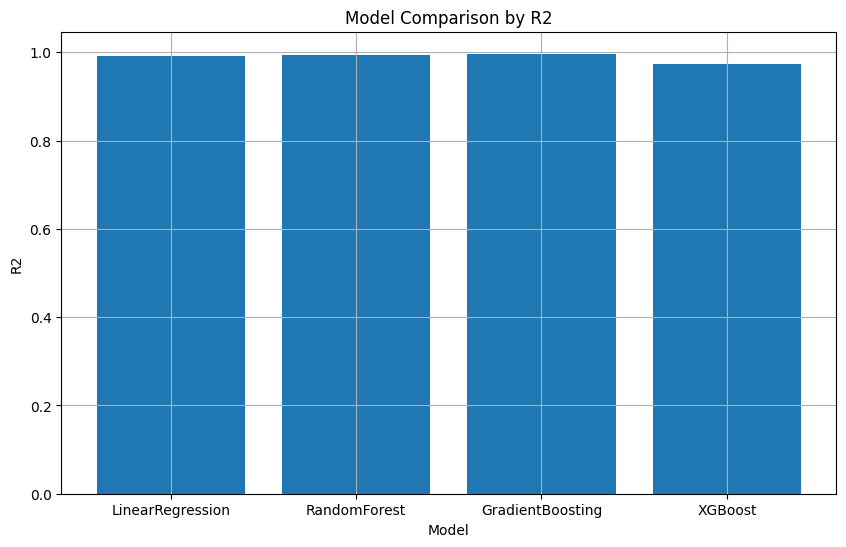

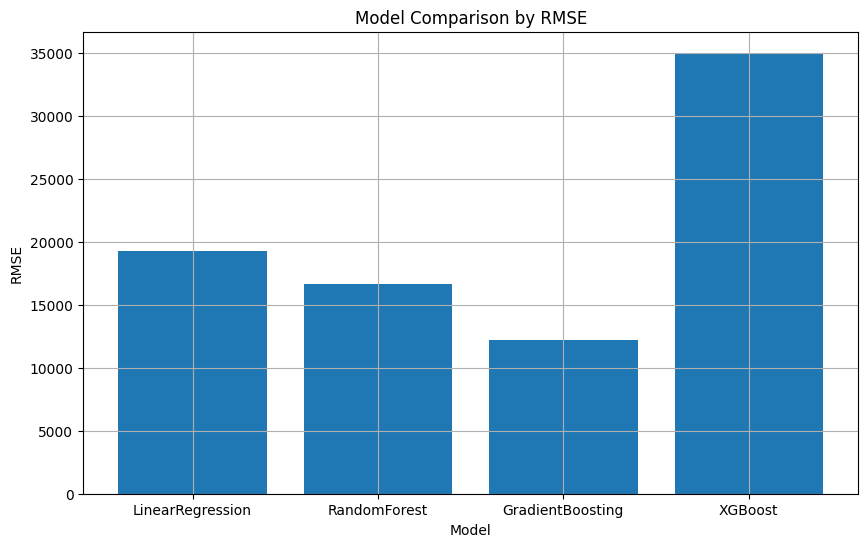

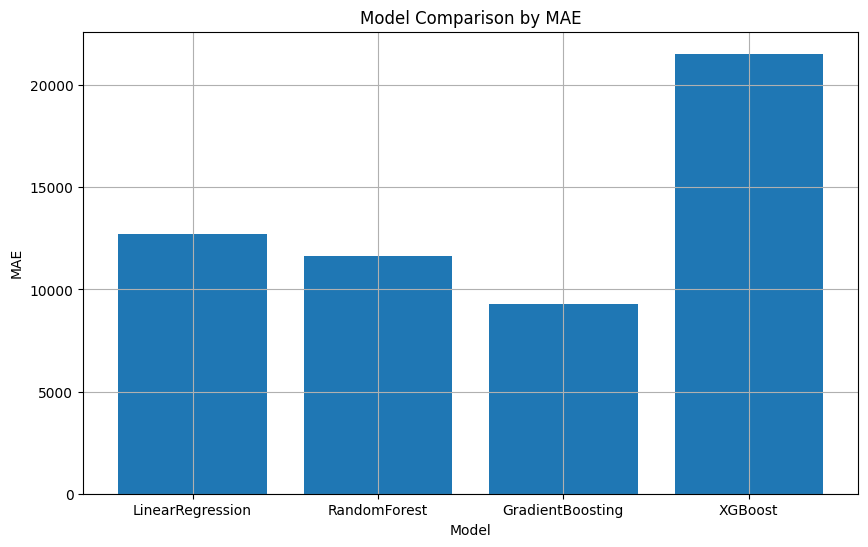

In [12]:
def plot_model_metrics(results, metric='r2'):
    names = list(results.keys())
    values = [results[name][metric] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, values)
    plt.title(f'Model Comparison by {metric.upper()}')
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

# Example usage:
plot_model_metrics(results, metric='r2')
plot_model_metrics(results, metric='rmse')
plot_model_metrics(results, metric='mae')

In [15]:
# Export best model info to YAML (matching model_config.yaml format)
import yaml, os

best_model_name = max(results, key=lambda n: results[n]["r2"])
best_model  = results[best_model_name]["model"]
best_params = results[best_model_name]["params"]
best_r2     = float(results[best_model_name]["r2"])
best_mae    = float(results[best_model_name]["mae"])
best_rmse   = float(results[best_model_name]["rmse"])

print(f"🏆 Best Model: {best_model_name}")
print(f"   R²: {best_r2:.4f} | MAE: {best_mae:.2f} | RMSE: {best_rmse:.2f}")

# Create config matching the format in src/configs/model_config.yaml
model_config = {
    "experiment": {
        "name": "HousePrice - Experiments",
        "run_name": f"{best_model_name}_on_featured_v3",
        "cv": 5
    },
    "model": {
        "name": "house_price_model",
        "best_model": best_model_name,
        "target_variable": "price",
        "scoring": "r2",
        "feature_sets": selected_features_dict,
        "parameters": best_params
    }
}

config_path = "/content/drive/MyDrive/Colab Notebooks/House Pricing/model_config.yaml"
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, "w") as f:
    yaml.dump(model_config, f, default_flow_style=False, sort_keys=False)

print(f"✅ Saved model config to {config_path}")
print("📋 Config structure:")
print("  - experiment: name, run_name, cv")
print("  - model: name, best_model, target_variable, scoring, feature_sets, parameters")

🏆 Best Model: GradientBoosting
   R²: 0.9968 | MAE: 9275.26 | RMSE: 12234.48
✅ Saved model config to /content/drive/MyDrive/Colab Notebooks/House Pricing/model_config.yaml
📋 Config structure:
  - experiment: name, run_name, cv
  - model: name, best_model, target_variable, scoring, feature_sets, parameters


In [16]:
# Display the generated config file
print("📄 Generated model_config.yaml content:")
print("=" * 50)
with open(config_path, 'r') as f:
    print(f.read())
print("=" * 50)
print("✅ This config file can be used by the train_model.py module")


📄 Generated model_config.yaml content:
experiment:
  name: HousePrice - Experiments
  run_name: GradientBoosting_on_featured_v3
  cv: 5
model:
  name: house_price_model
  best_model: GradientBoosting
  target_variable: price
  scoring: r2
  feature_sets:
    rfe:
    - sqft
    - bedrooms
    - bathrooms
    - location
    - year_built
    - condition
    - house_age
    - price_per_sqft
    - bed_bath_ratio
    - total_rooms
  parameters:
    learning_rate: 0.1
    max_depth: 3
    n_estimators: 250

✅ This config file can be used by the train_model.py module


In [17]:
# === Cell A: Chọn best model + seed tái lập ===
import os, random, numpy as np

# Lấy best theo R2 từ biến `results` đã có ở Cell 3
best_model_name = max(results, key=lambda n: results[n]["r2"])
best_model  = results[best_model_name]["model"]
best_params = results[best_model_name]["params"]
best_r2     = float(results[best_model_name]["r2"])
best_rmse   = float(results[best_model_name]["rmse"])
best_mae    = float(results[best_model_name]["mae"])

print(f"🏆 Best: {best_model_name} | R²={best_r2:.4f} | RMSE={best_rmse:.2f} | MAE={best_mae:.2f}")
print("Best params:", best_params)

# Seed cho tái lập
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

try:
    # một số model cho phép set random_state sau khi khởi tạo
    if hasattr(best_model, "random_state"):
        setattr(best_model, "random_state", SEED)
except Exception:
    pass

# Tạo thư mục lưu hình ảnh
import pathlib
PLOT_DIR = pathlib.Path("/content/plots"); PLOT_DIR.mkdir(parents=True, exist_ok=True)

🏆 Best: GradientBoosting | R²=0.9968 | RMSE=12234.48 | MAE=9275.26
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}


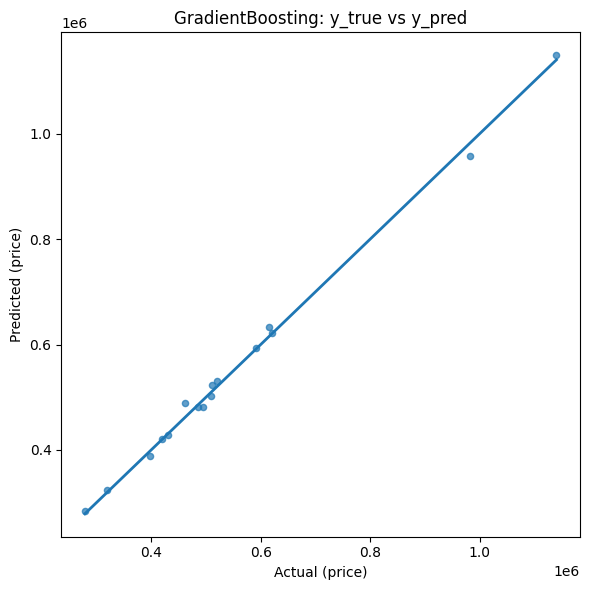

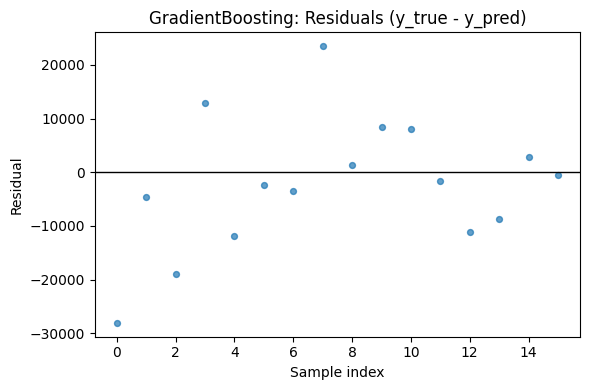

✅ Logged scatter & residual plots to MLflow (post_analysis/best_model_plots)


In [18]:
# === Cell B: Phân tích best model (scatter & residuals) + log artifacts ===
import matplotlib.pyplot as plt
import mlflow

# Dự đoán trên test
y_pred_best = best_model.predict(X_test)
residuals = y_test - y_pred_best

# 1) Scatter y_true vs y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, s=20, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2)  # đường y=x
plt.title(f"{best_model_name}: y_true vs y_pred")
plt.xlabel("Actual (price)")
plt.ylabel("Predicted (price)")
scatter_path = str(PLOT_DIR / f"{best_model_name}_ytrue_ypred.png")
plt.tight_layout(); plt.savefig(scatter_path); plt.show()

# 2) Biểu đồ residuals
plt.figure(figsize=(6,4))
plt.scatter(range(len(residuals)), residuals, s=18, alpha=0.7)
plt.axhline(0, color="black", lw=1)
plt.title(f"{best_model_name}: Residuals (y_true - y_pred)")
plt.xlabel("Sample index")
plt.ylabel("Residual")
resid_path = str(PLOT_DIR / f"{best_model_name}_residuals.png")
plt.tight_layout(); plt.savefig(resid_path); plt.show()

# Log các hình này dưới 1 run gọn tên "post_analysis/best_model_plots"
with mlflow.start_run(run_name="post_analysis", nested=False):
    with mlflow.start_run(run_name="best_model_plots", nested=True):
        mlflow.set_tag("phase", "post_analysis")
        mlflow.set_tag("feature_set", "RFE")
        mlflow.set_tag("best_model_name", best_model_name)
        mlflow.log_metric("best_r2", best_r2)
        mlflow.log_metric("best_rmse", best_rmse)
        mlflow.log_metric("best_mae", best_mae)
        mlflow.log_artifact(scatter_path, artifact_path="plots")
        mlflow.log_artifact(resid_path,   artifact_path="plots")

print("✅ Logged scatter & residual plots to MLflow (post_analysis/best_model_plots)")

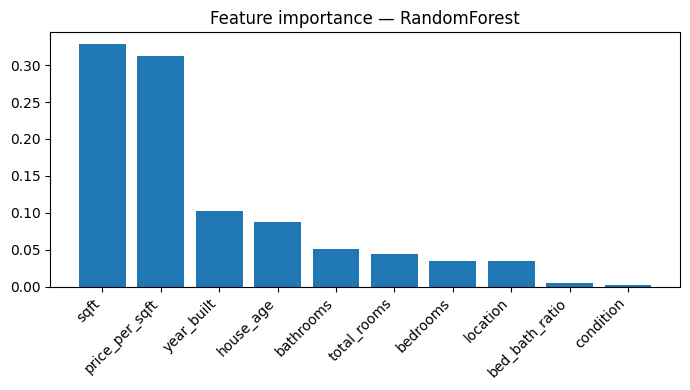

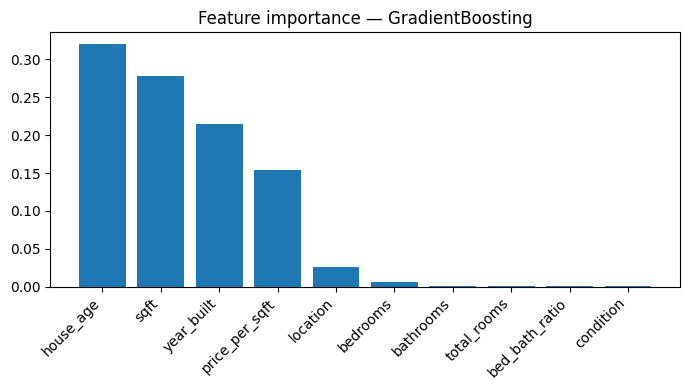

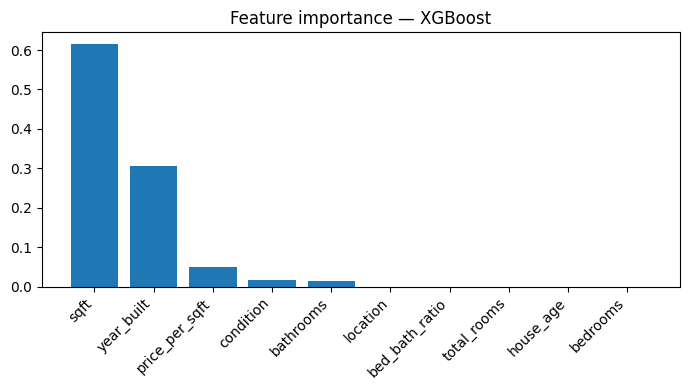

✅ Logged feature importance (nếu có) to MLflow.


In [19]:
# === Cell C: Feature Importance (nếu có) + log artifacts ===
import matplotlib.pyplot as plt
import numpy as np
import mlflow

def plot_and_save_importance(model, model_name, feature_names, out_path):
    importances = getattr(model, "feature_importances_", None)
    if importances is None:
        return False
    order = np.argsort(importances)[::-1]
    plt.figure(figsize=(7,4))
    plt.bar(np.array(feature_names)[order], np.array(importances)[order])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Feature importance — {model_name}")
    plt.tight_layout(); plt.savefig(out_path); plt.show()
    return True

with mlflow.start_run(run_name="post_analysis", nested=False):
    with mlflow.start_run(run_name="feature_importance", nested=True):
        mlflow.set_tag("phase", "post_analysis")
        done_any = False
        for name in results:
            model = results[name]["model"]
            out_path = str(PLOT_DIR / f"{name}_feature_importance.png")
            ok = plot_and_save_importance(model, name, X_train.columns, out_path)
            if ok:
                mlflow.log_artifact(out_path, artifact_path="plots/feature_importance")
                done_any = True
        if not done_any:
            print("ℹ️ Không model nào có thuộc tính feature_importances_. Bỏ qua bước này.")
print("✅ Logged feature importance (nếu có) to MLflow.")

In [20]:
# === Cell D: Đăng ký best model vào Model Registry ===
import mlflow, mlflow.sklearn
from mlflow.models import infer_signature

# Chuẩn bị example & signature (giống Cell 3 để đồng nhất)
example = X_test.iloc[:5].copy()
int_cols = example.select_dtypes(include=["int","int32","int64"]).columns
if len(int_cols): example[int_cols] = example[int_cols].astype("float64")
signature = infer_signature(example, best_model.predict(example))

# Tên model trong Registry (tuỳ bạn đặt)
REG_NAME = "house_price_model_registry"

with mlflow.start_run(run_name="post_analysis", nested=False):
    mlflow.set_tag("phase", "registry")
    mlflow.set_tag("best_model_name", best_model_name)
    mlflow.log_params(best_params)
    mlflow.log_metrics({"best_r2": best_r2, "best_rmse": best_rmse, "best_mae": best_mae})

    mlflow.sklearn.log_model(
        sk_model=best_model,
        name=REG_NAME,                         # tên artifact trong run
        registered_model_name=REG_NAME,        # đẩy vào Model Registry
        signature=signature,
        input_example=example
    )

print(f"✅ Registered best model to MLflow Model Registry as '{REG_NAME}'")

✅ Registered best model to MLflow Model Registry as 'house_price_model_registry'


Successfully registered model 'house_price_model_registry'.
Created version '1' of model 'house_price_model_registry'.
